# AtLAST Predictions
Here, you can find another example of using this simulation tool for predictions. But now, in this scenario, we'll adjust the parameters to align with a small instrument that could be mounted on AtLAST. AtLAST will have a broad 2-degree field of view (FOV) and offer a 10" resolution at 150 GHz. This configuration provides a more comprehensive, high spatial dynamic range, ideal for observing phenomena such as the Sunyaev-Zeldovich effect in galaxy clusters.

In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import cmocean

from astropy.io import fits
from astropy.wcs import WCS
from astropy import units as u
from astropy.constants import c
from astropy.coordinates import SkyCoord

In [2]:
from maria import Simulation
from maria.map import mappers
from maria import TOD

In [3]:
import matplotlib
plt.style.use('/lustre/home/jvmarrewijk/eszee/Notebooks/thesis.mplstyle')
matplotlib.rc('image', origin='lower')

In [4]:
pointing_center  = (260.0, -10.0) #RA and Dec in degrees

pixel_size       = 0.0009765625 # degree
integration_time = 8.6 * 60.0 #seconds
FREQ             = 92.0 #GHZ

scanning_speed   = 0.5 #deg/s
sample_rate      = float(int(225. * (scanning_speed/0.5) * (FREQ/92.0)**2))  #Hz

field_of_view    = 0.25 # deg
scanning_radius  = field_of_view
ndets            = float(int(3000 * (field_of_view/0.25)**2 * (FREQ/92.0)**2))

print(ndets, sample_rate)
inputfile = "../../../maps/big_cluster0.fits"

outfile_map = '/lustre/home/jvmarrewijk/Single_dish_emulator/output/AtLAST_Cluster_{}min_noisyTrue_map.fits'.format(
    int(integration_time/60),
)

atm_model            = "2d"    # The atmospheric model, set to None if you want a noiseless observation.
white_noise_level    = 5e-5
pink_noise_level     = 0.05

3000.0 225.0


In [5]:
# - Input figure
hdu = fits.open(inputfile)
header = hdu[1].header
    
wcs_input = WCS(header, naxis=2)

CLUSTER =../DIANOGA/BH2015/D10 / cluster name                                    [astropy.io.fits.card]
OUTTYPE =Comptonization y para / outputtype                                      [astropy.io.fits.card]


### Fine-Tuning Simulation Parameters

To make predictions for AtLAST, several adjustments are required. Firstly, we need to change the pointing center. AtLAST is located near the APEX telescope in the southern hemisphere, so we set the pointing center to a Declination of -10. Additionally, we need to chance the atmospheric conditions. The defeault is set to mid-February at 6 am UT, which is an ideal time for observing with MUSTANG-2 on the GBT but not for AtLAST at Chajnantor. To achieve this, we modify the `start_time` key to August. This change also necessitates adjusting the Right Ascension (RA) of the pointing to ensure that the source remains above the horizon during the observation.

Furthermore, we overwrite the field of view to be 2 degrees and set the scan radius of the daisy scan to 1.3 degrees. We also adjust the detector bandwidth to 52 GHz with a total of 2000 detectors, and set a scan period of 120 seconds. 

Now, it's important to note that we haven't yet developed a mapper that can handle AtLAST's large FOV. Most of the contamination will likely be a common mode in the atmosphere, which needs proper Fourier filtering. This aspect is still a work in progress. Therefore, for the time being, we conduct noiseless observations by setting `atm_model = None`.

In [6]:
sim = Simulation(
    
    # Mandatory weather settings
    # ---------------------
    array    = "AtLAST", 
    pointing = "daisy", 
    site     = "APEX",  
    
    # Noise settings:
    # ----------------
    atmosphere_model  = atm_model,
    white_noise_level = white_noise_level,
    pink_noise_level  = pink_noise_level,
    pwv_rms_frac      = 0.07,

    # True sky input
    # ---------------------
    map_file   = inputfile,        
    map_units  = "Jy/pixel",       
    map_res    = pixel_size,       
    map_center = pointing_center,  
    map_freqs  = [FREQ],
    
    # AtLAST Observational setup
    # ----------------------------
    integration_time = integration_time, 
    sample_rate      = sample_rate,      
    scan_center      = pointing_center,  
    start_time       = "2022-08-01T23:00:00",
    pointing_frame   = "ra_dec", 
    
    field_of_view    = field_of_view,
    bands  = {"f090": {"n": ndets, 
                                 "band_center": FREQ, 
                                 "band_width": 52.0
                                }
                       },
    
    scan_options     = {"speed":  scanning_speed, 
                        "radius": scanning_radius, 
                        "petals": 2.11
                       },
)

CLUSTER =../DIANOGA/BH2015/D10 / cluster name                                    [astropy.io.fits.card]
OUTTYPE =Comptonization y para / outputtype                                      [astropy.io.fits.card]


In [7]:
tod = sim.run()

ran atmospheric simulation in 347.7 seconds


In [8]:
# tod.to_fits(outfile_table)

### Visualizing the TOD Data

In this section, we present the same array and TOD visualizations as in the MUSTANG-2 case, but this time for AtLAST:

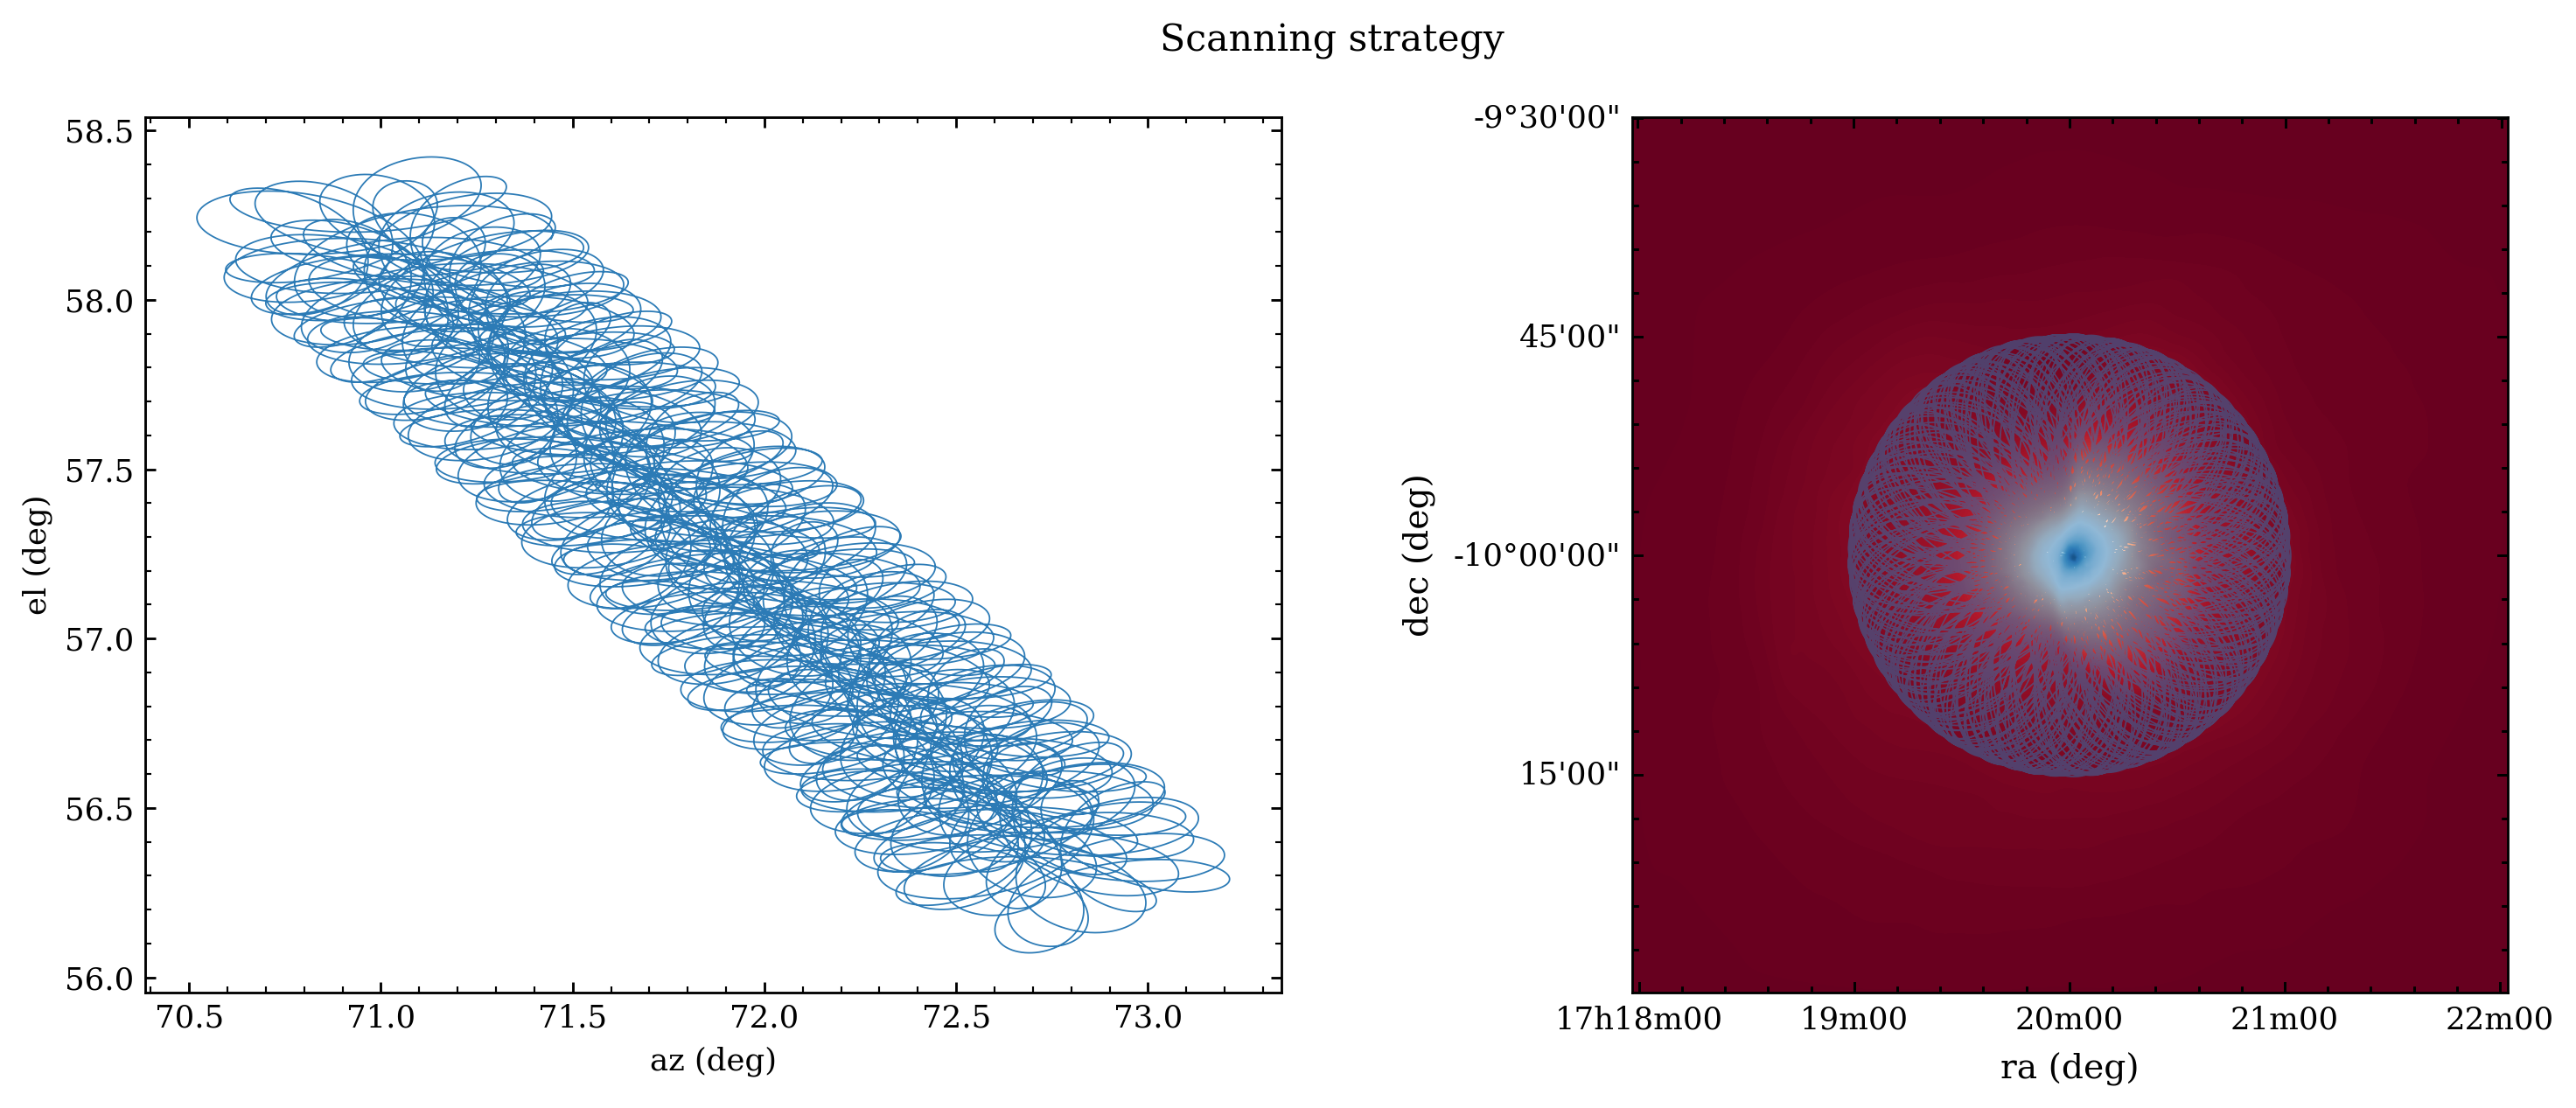

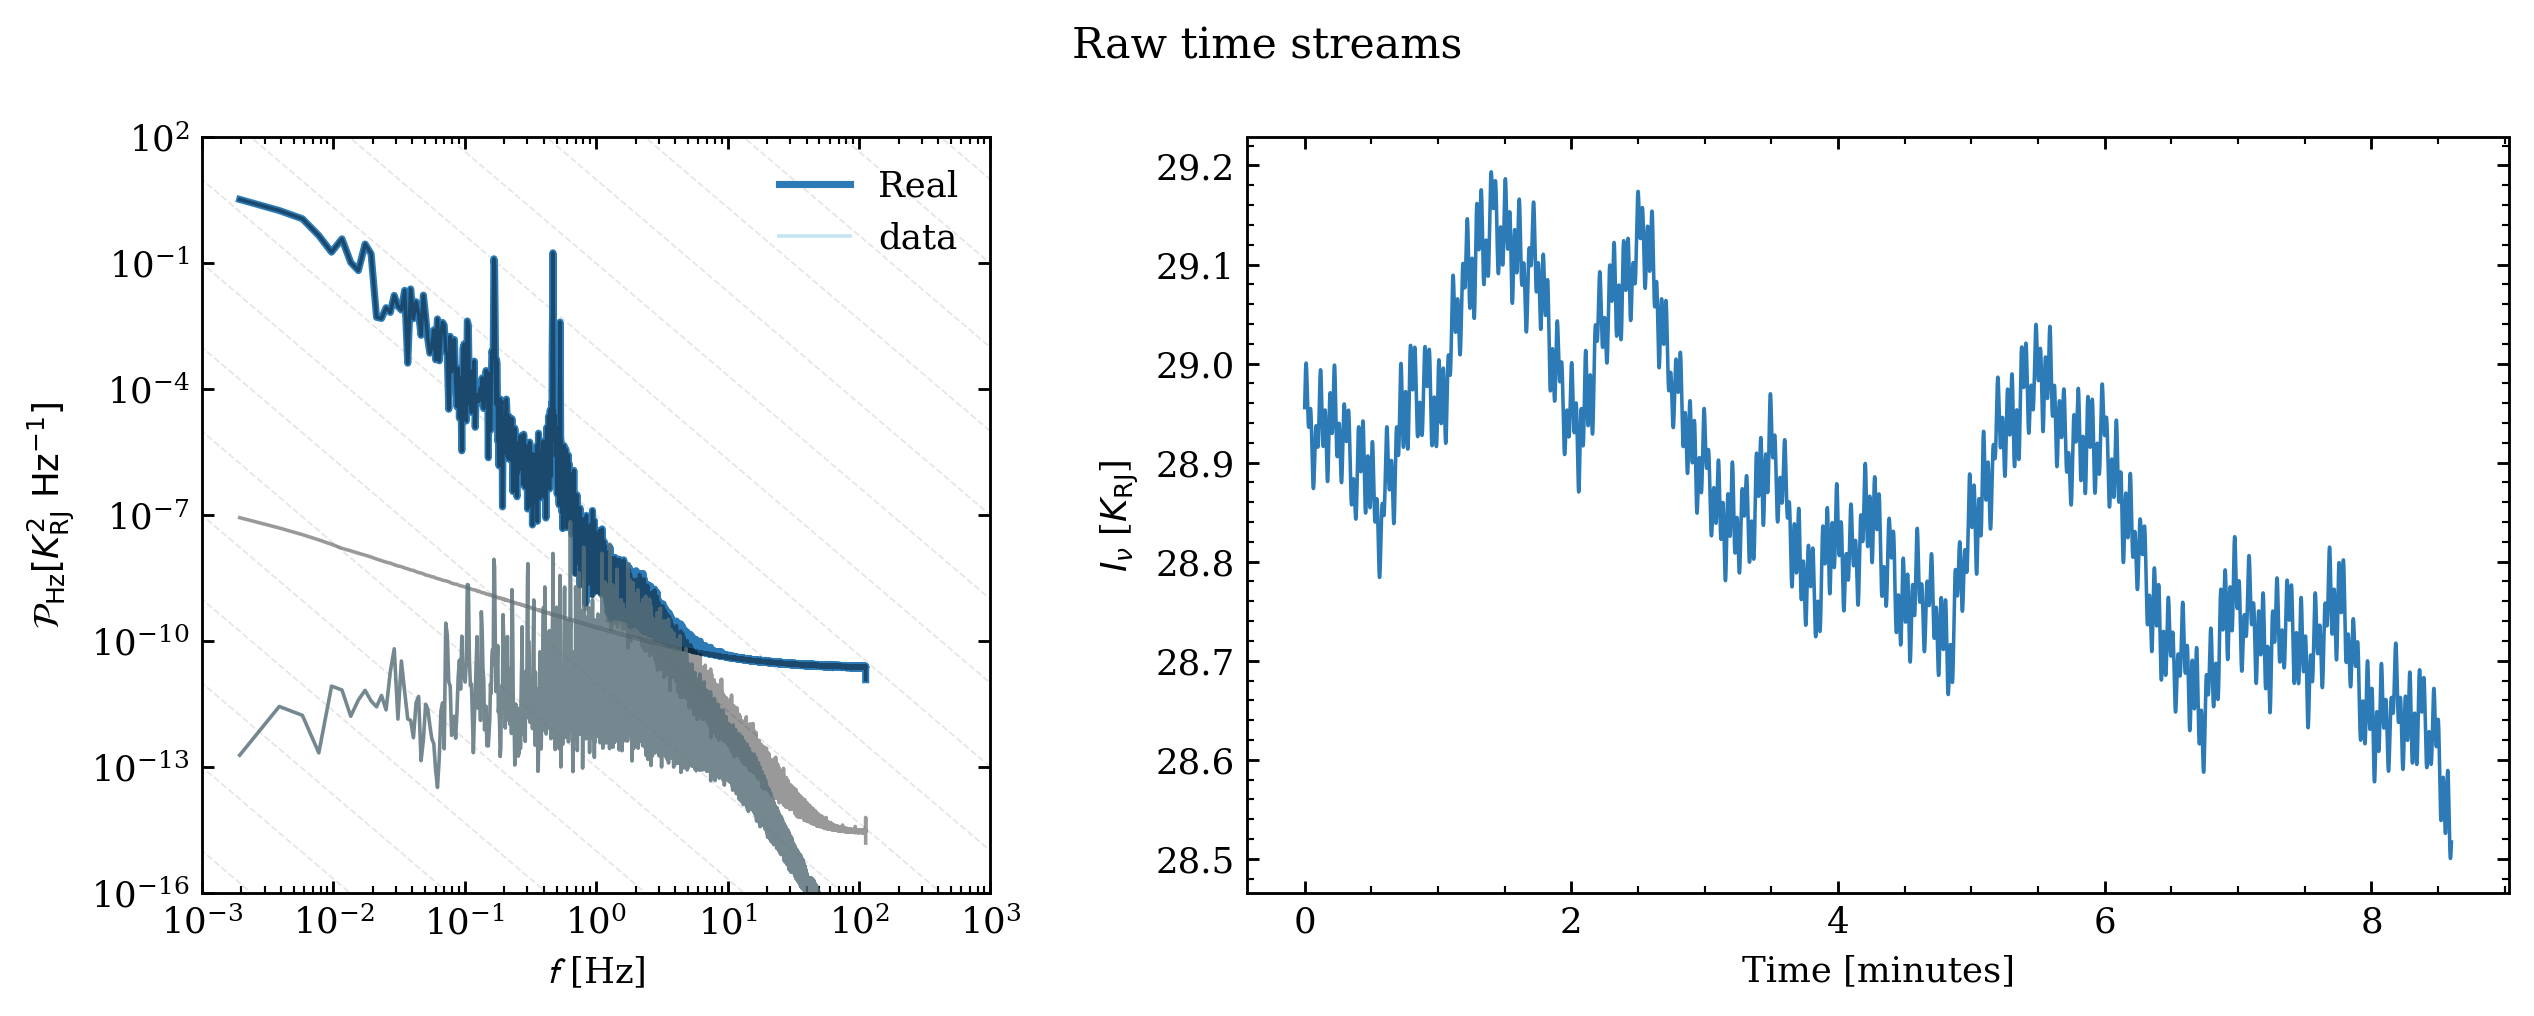

In [9]:
# visualize scanning patern
# -----------------------
cmap = "RdBu_r"

fig = plt.figure(dpi=256, tight_layout=True)
fig.set_size_inches(12, 5, forward=True)
fig.suptitle("Scanning strategy")

# - Plot
ax = plt.subplot(1, 2, 1)

ax.plot(np.degrees(tod.boresight.az), np.degrees(tod.boresight.el), lw=5e-1)
ax.set_xlabel("az (deg)"), ax.set_ylabel("el (deg)")

ax = plt.subplot(1, 2, 2, projection=wcs_input)
im = ax.imshow(hdu[1].data, cmap=cmap)

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

sky = SkyCoord(np.degrees(tod.boresight.ra) * u.deg, np.degrees(tod.boresight.dec) * u.deg)
pixel_sky = wcs_input.world_to_pixel(sky)
ax.plot(pixel_sky[0], pixel_sky[1], lw=5e-1, alpha=0.5)
ax.set_xlabel("ra (deg)"), ax.set_ylabel("dec (deg)")
plt.show()

# visualize powerspectrum
# -----------------------
f, ps = sp.signal.periodogram(tod.data, fs=1/(tod.time[1] - tod.time[0]), window="tukey")

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=256, tight_layout=True, gridspec_kw={'width_ratios': [1, 1.6]})
fig.suptitle('Raw time streams')

for i in range(-20,20,2): axes[0].plot(np.logspace(-7, 3,100), np.logspace(-7, 3,100) ** (-8 / 3)/1e11/(10**i), c = 'gray', alpha = 0.2, ls = '--', lw = 0.5)

axes[0].plot(f[1:], ps.mean(axis=0)[1:], label="Real", alpha = 1., c = 'C0', lw = 2, ls = '-')
for key in tod._data.keys():
    f_, ps_ = sp.signal.periodogram(tod._data[key], fs=1/(tod.time[1] - tod.time[0]), window="tukey")
    
    if key == 'map':
        axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .7, label= 'data', c = 'C1', lw = 1, ls = '-')
    else:
        axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = 'k', lw = 1, ls = '-')

axes[0].plot(f_[1:], ps_.mean(axis=0)[1:], alpha = .4, c = 'k', lw = 1, ls = '-')

axes[0].set_xlabel(r"$\mathcal{f}$ [Hz]"), 
axes[0].set_ylabel(r"$\mathcal{P}_{\rm Hz}[K_{\rm RJ}^2~{\rm Hz}^{-1}]$")
axes[0].loglog()
axes[0].legend(loc = 1, frameon=False)
axes[0].axis(xmin=1e-3, xmax = 1e3, ymin = 1e-16, ymax = 1e2)

axes[1].set_xlabel('Time [minutes]'), axes[1].set_ylabel("\n"+r'$I_\nu$ [$K_{\rm RJ}$]')
axes[1].plot((tod.time - tod.time[0])/60, tod.data.mean(axis=0), label = 'Real', alpha = 1., c = 'C0', lw = 1, ls = '-')
plt.show()

## Map-Making

As previously mentioned, we must disable Fourier filtering. Additionally, we have adjusted the height and width of the map to match the realistic AtLAST field of view, which spans several degrees.

In [10]:
# scan velocity
fov               = (field_of_view*u.degree).to(u.arcsec)
scn_velocity      = scanning_speed * u.degree/u.s
filter_freq       = (scn_velocity/fov).to(u.Hz).value

In [11]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(tod.boresight.center_ra, tod.boresight.center_dec), 
                   frame="ra_dec", 
                   width=np.radians(1.),
                   height=np.radians(1.),
                   res=np.radians(4./3600.),
                   smoothing= 16,
                   degrees = False,
                   filter_data=True,
                   ffilter =filter_freq/2,
                   n_modes_to_remove=1,
                  )

mapper.add_tods(tod)
mapper.run()

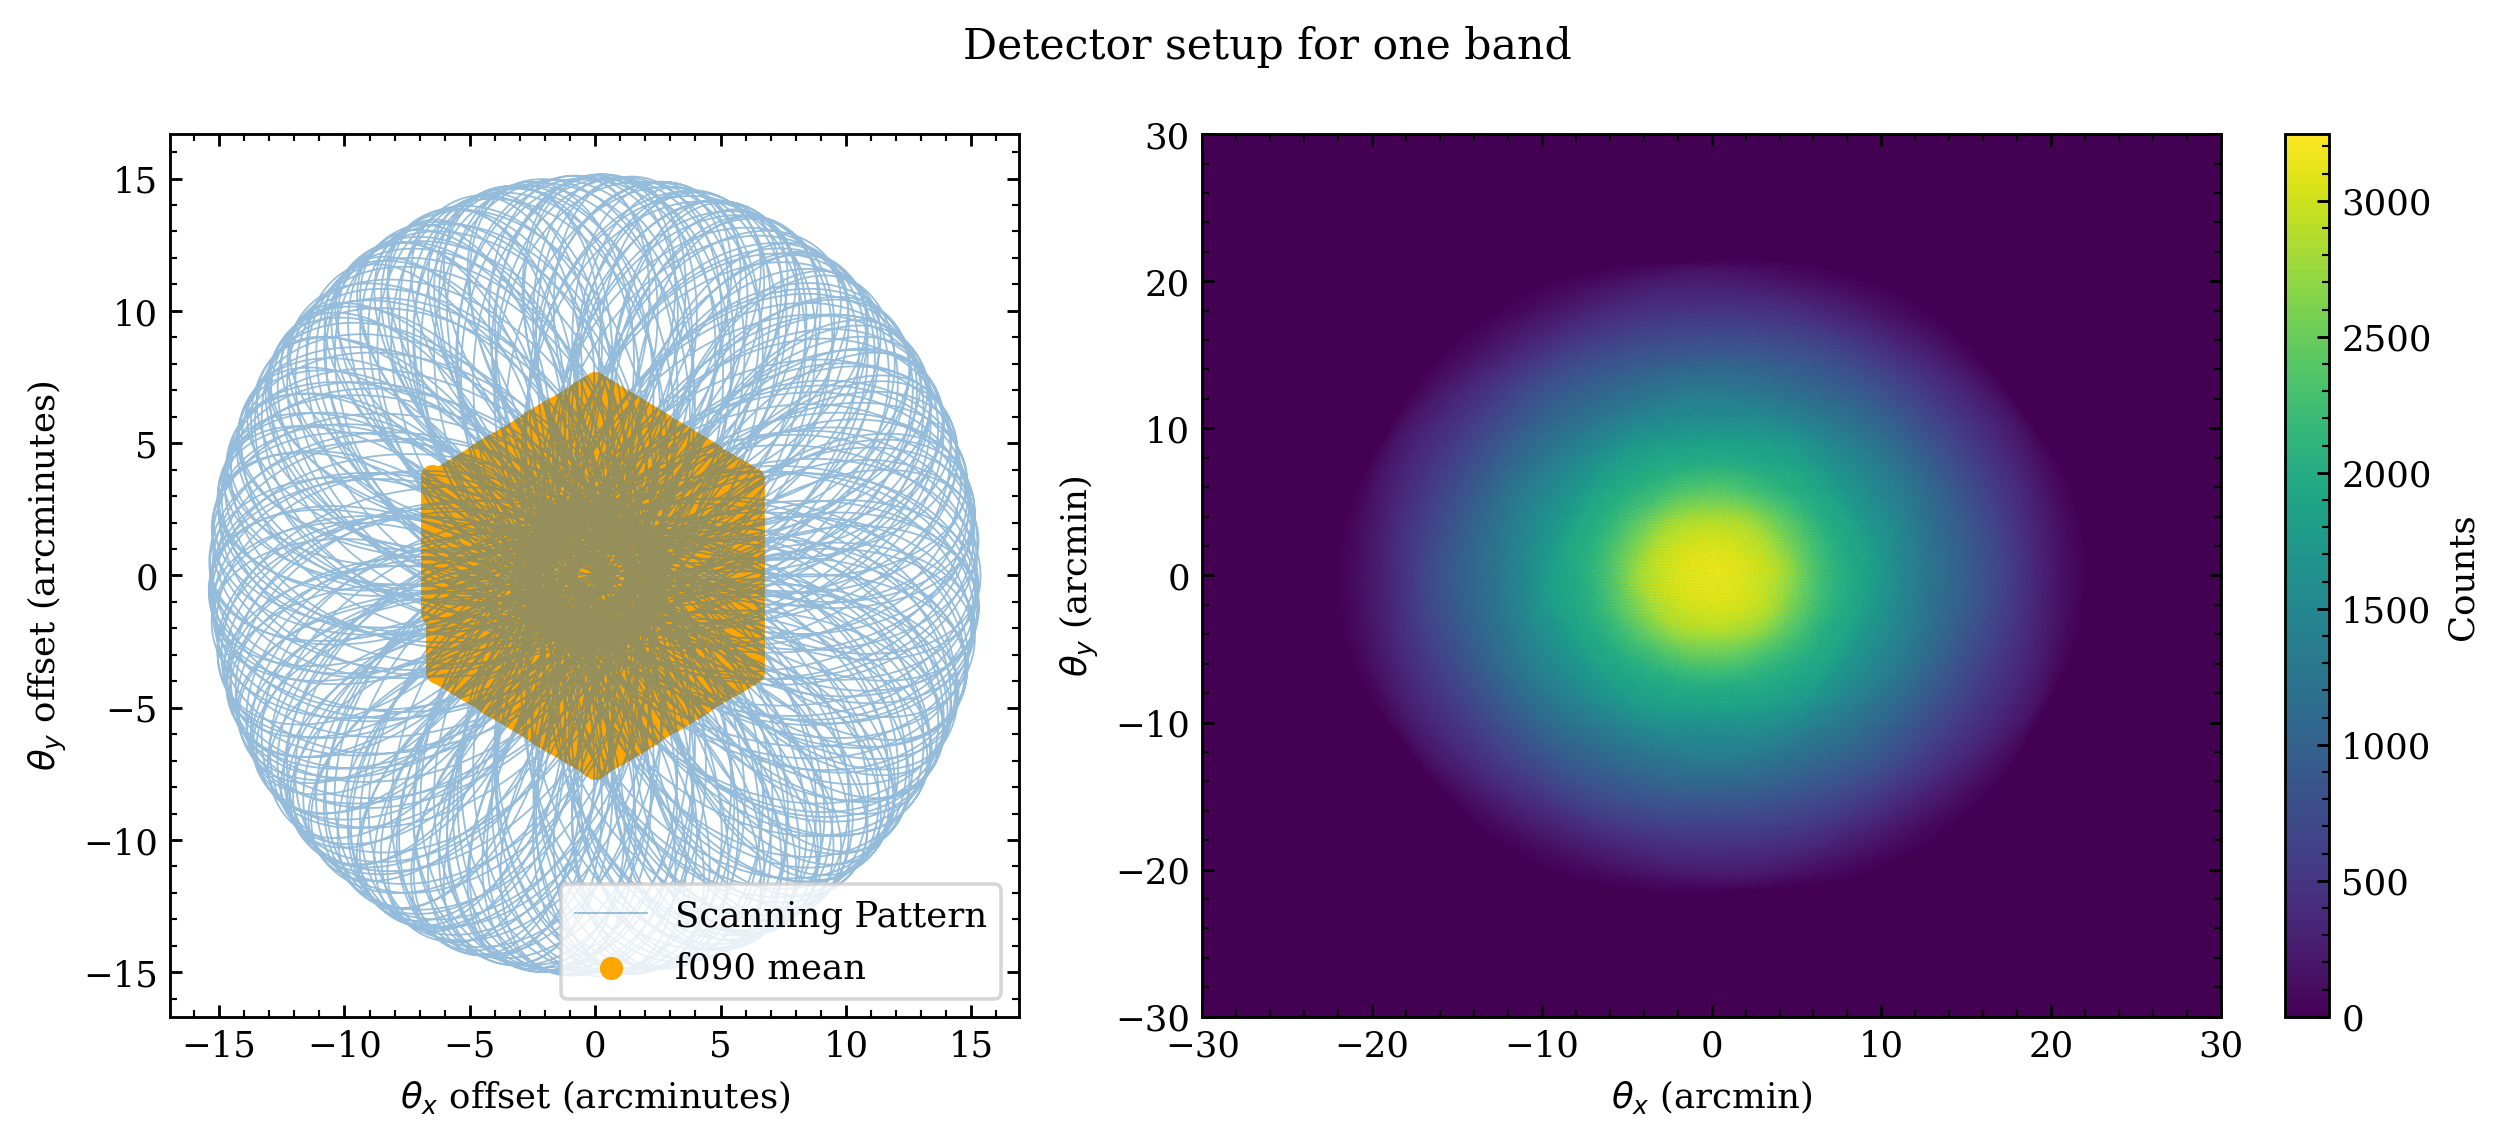

In [12]:
fig, axes = plt.subplots(
    1,
    2,
    figsize=(10, 4.5),
    dpi=256,
    tight_layout=True,
    gridspec_kw={"width_ratios": [1, 1.5]},
)
fig.suptitle("Detector setup for one band")

for uband in sim.array.bands:
    band_mask = sim.array.dets.band == uband

    axes[0].plot(
        60 * np.degrees(tod.boresight.ra - tod.boresight.ra.mean()),
        60 * np.degrees(tod.boresight.dec - tod.boresight.dec.mean()),
        lw=5e-1,
        alpha=0.5,
        label="Scanning Pattern",
    )
    axes[0].scatter(
        60 * np.degrees(sim.array.offset_x[band_mask]),
        60 * np.degrees(sim.array.offset_y[band_mask]),
        label=f"{uband} mean",
        lw=5e-1,
        c="orange",
    )

axes[0].set_xlabel(r"$\theta_x$ offset (arcminutes)")
axes[0].set_ylabel(r"$\theta_y$ offset (arcminutes)")
axes[0].legend()

xs, ys = np.meshgrid(
    60 * np.rad2deg((mapper.x_bins[1:] + mapper.x_bins[:-1]) / 2),
    60 * np.rad2deg((mapper.y_bins[1:] + mapper.y_bins[:-1]) / 2),
)

im = axes[1].pcolormesh(
    xs,
    ys,
    mapper.map_cnts[tod.dets.band[0]],
    label="Photon counts in band " + tod.dets.band[0],
)

axes[1].set_xlabel(r"$\theta_x$ (arcmin)"), axes[1].set_ylabel(r"$\theta_y$ (arcmin)")
cbar = plt.colorbar(im, ax=axes[1])
cbar.set_label("Counts")

plt.show()

## Save & Visualize

In [13]:
mapper.save_maps(outfile_map)

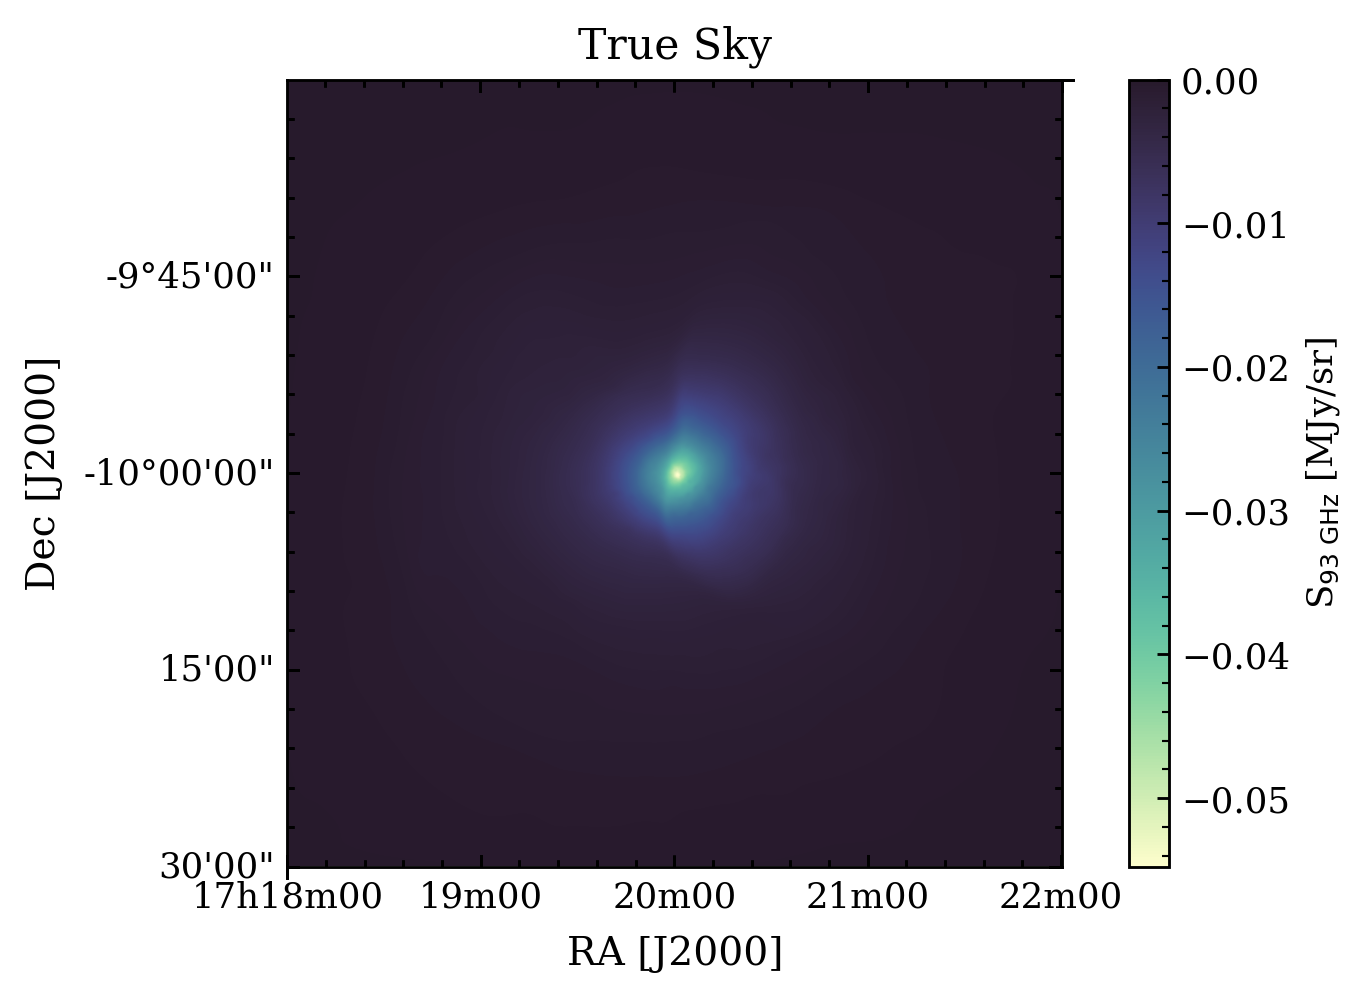

/lustre/home/jvmarrewijk/Single_dish_emulator/output/AtLAST_Cluster_8min_noisyTrue_map.fits


CLUSTER =../DIANOGA/BH2015/D10 / cluster name                                    [astropy.io.fits.card]
OUTTYPE =Comptonization y para / outputtype                                      [astropy.io.fits.card]


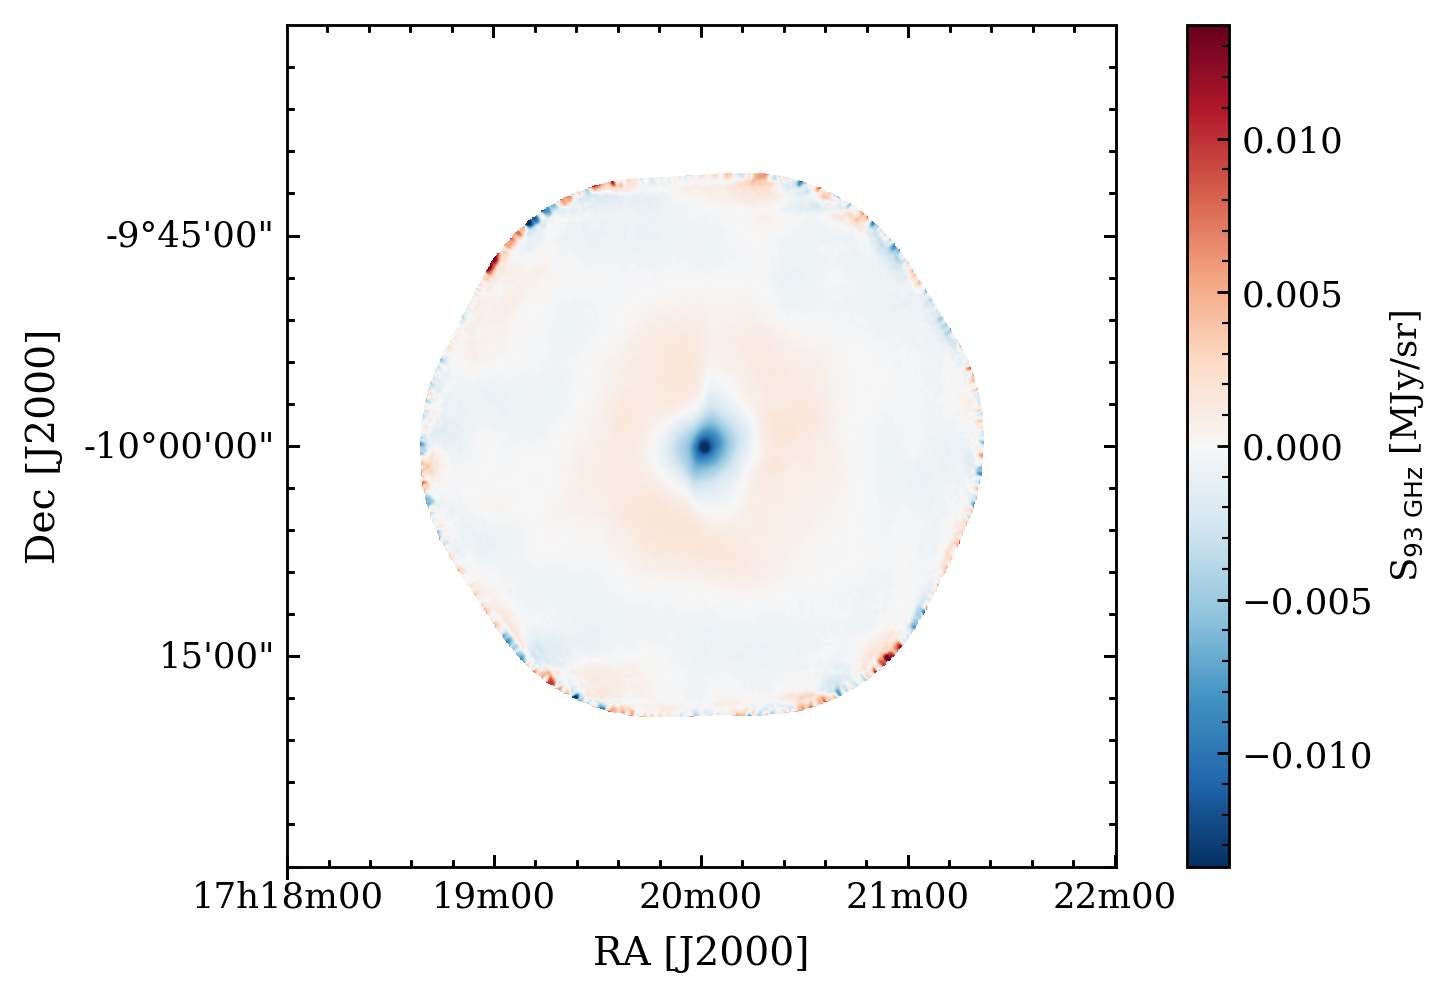

In [16]:
sky_l = SkyCoord((pointing_center[0] - 0.5) * u.deg, (pointing_center[1] - 0.5) * u.deg)
sky_u = SkyCoord((pointing_center[0] + 0.5) * u.deg, (pointing_center[1] + 0.5) * u.deg)

fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

# - Plot Input sky
ax = plt.subplot(1, 1, 1, projection=wcs_input)
ax.set_title("True Sky")
im = ax.imshow(
    hdu[1].data / (np.radians(pixel_size)) ** 2 / 1e6,
    vmin=np.nanmin(hdu[1].data / (np.radians(pixel_size)) ** 2 / 1e6),
    vmax=0,
    cmap=cmocean.cm.deep,
)
cbar = plt.colorbar(im, ax=ax, shrink=1.0)
cbar.set_label(r"S$_{93~\rm GHz}$ [MJy/sr]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_input.world_to_pixel(sky_l)
pixel_sky_u = wcs_input.world_to_pixel(sky_u)
ax.axis(
    xmin=pixel_sky_l[0], ymin=pixel_sky_l[1], xmax=pixel_sky_u[0], ymax=pixel_sky_u[1]
)
plt.show()

print(outfile_map)

# - Plot Mock observation
outputfile = outfile_map

hdu_out = fits.open(outputfile)
wcs_output = WCS(hdu_out[0].header, naxis=2)

# - Plot
fig = plt.figure(dpi=256, tight_layout=False)
fig.set_size_inches(6, 4, forward=True)

ax = plt.subplot(1, 1, 1, projection=wcs_output)

im = ax.imshow(hdu_out[0].data[0]/(mapper.res**2)/1e6, cmap=cmap,
      vmin=np.nanmin(hdu[1].data / (np.radians(pixel_size)) ** 2 / 1e6)/4,
      vmax=-1*np.nanmin(hdu[1].data / (np.radians(pixel_size)) ** 2 / 1e6)/4,
              )

# im = ax.imshow(hdu_out[0].data[0]*1e6, cmap=cmap,
#       vmin=-3*np.nanstd(hdu_out[0].data[0] * 1e6),
#       vmax=3*np.nanstd(hdu_out[0].data[0] * 1e6),
# )

cbar = plt.colorbar(im, ax=ax, shrink=1.0)
# cbar.set_label(r"$I_\nu$ $[\mu K_{RJ}]$")
cbar.set_label(r"S$_{93~\rm GHz}$ [MJy/sr]")

ra, dec = ax.coords
ra.set_major_formatter("hh:mm:ss")
dec.set_major_formatter("dd:mm:ss")
ra.set_axislabel(r"RA [J2000]", size=11)
dec.set_axislabel(r"Dec [J2000]", size=11)
ra.set_separator(("h", "m"))

pixel_sky_l = wcs_output.world_to_pixel(sky_l)
pixel_sky_u = wcs_output.world_to_pixel(sky_u)

ax.axis(xmin = pixel_sky_l[0], ymin = pixel_sky_l[1], xmax = pixel_sky_u[0], ymax = pixel_sky_u[1])
plt.savefig("/lustre/home/jvmarrewijk/Single_dish_emulator/paper_plots/AtLAST_noiesemap.pdf")
plt.show()